# 1. k-means on digits

Use K-means clustering on the MNIST dataset (which can be imported with `from sklearn.datasets import load_digits`) to learn to identify the 10 digits in an unsupervised manner.

1. Plot the `cluster_centers_` from a kmeans clustering (which should be shape `(10,64)`) onto a `8x8` grid (hint: use `kmeans.cluster_centers_.reshape`)

2. Reorganize the clusters so that each of your learned clusters labels overlap with the true label (eg. if the digit 4 has the cluster label 9, you want to remap it to 4). Hint: You can use the statistical mode of your clusters and the real label to match them

3. Now that your cluster labels are matched to the supervised learning labels, check the classification accuracy of your clustering model (accuracy score and confusion matrix). Give a two paragraph interpretation.

4. Use the Fowlkes-Mallows score to evaluate your clustering against the true labels. Give a two paragraph interpretation comparing to your result in #3.

# 1.

In [2]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [7]:
digits = load_digits()

In [11]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

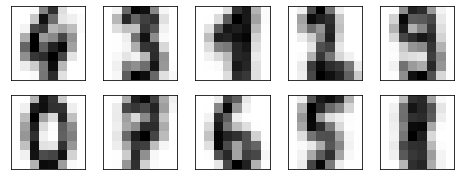

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))

centers = kmeans.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

# 2.

In [23]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# 3.

In [17]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(digits.target, labels)

print("Accuracy of unsupervised clustering:", accuracy)



Accuracy of unsupervised clustering: 0.7952142459654981


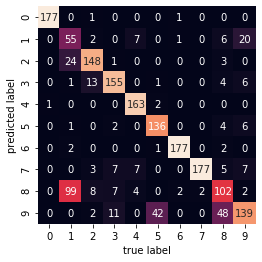

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(digits.target, labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');



In [ ]:
"""
Interpreting the accuracy and confusion matrix.
based on the accuracy score it looks like I was able to get 
the correct grouping of digits for around 80% of the input digits.

But based on the visualized cluster centers from part 1,
looking at the confusion matrix it seems the main place of confusion is
with the eights and ones.
"""

# 4.

In [26]:
from sklearn.metrics.cluster import fowlkes_mallows_score

fowlkes_mallows_score(digits.target, labels)

0.7041643183491655

In [ ]:
"""
Based on the fowlkes_mallows_score vs the accuracy score,
I got roughly 70% on the fowlkes_mallows_score, which is 10% less than I got with 
the accuracy score. I think this is because the fowlkes_mallows_score is more about precision and recall.
because there has been some confusion with the eights and ones in our cluster,
the precision score would naturally be lower because of that.

Seeing as we got roughly 70%, this indicates a decent similarity between
clusters.
"""

# 2: Image Compression second pass

Use any the clustering algorithms we see to produce what you think is the best image compression ratio that is **visually indistinguishable** from the original image (recall in the lecture the result was very compressed but also much uglier)

Justify your choice and process in 3 paragraphs.

In [ ]:
"""
So i decided to use my own image just to practice, but when looking at compression
if I decrease the number of clusters then the image loses a lot of color and saturation,
if I increase the cluster size, the image becomes over saturated and takes forever to run.

I happened to come across a perfect number of 64 clusters for basic image comp.
I suspect that if I were to compress an image that was taken by a better camera
with better quality, id have to increase the number of clusters.
Probably doubling it, as there would be points of color to compress.
"""

In [46]:
from skimage import io

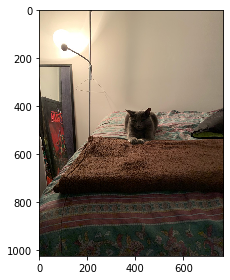

In [47]:
#Read the image
image = io.imread('/Users/kalebmckenzie/Documents/GitHub/4-3-clustering/data/65BE3156-FAC9-4A23-AB58-9180080ACA8D_1_105_c.jpeg')
io.imshow(image)
io.show()

In [48]:
#Dimension of the original image
rows = image.shape[0]
cols = image.shape[1]

In [49]:
#Flatten the image
image = image.reshape(rows*cols, 3)

In [50]:
#Implement k-means clustering to form k clusters
kmeans = KMeans(n_clusters=64)
kmeans.fit(image)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=64, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [51]:
#Replace each pixel value with its nearby centroid
compressed_image = kmeans.cluster_centers_[kmeans.labels_]
compressed_image = np.clip(compressed_image.astype('uint8'), 0, 255)

In [52]:
#Reshape the image to original dimension
compressed_image = compressed_image.reshape(rows, cols, 3)

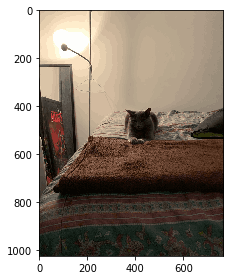

In [53]:
#Save and display output image
io.imsave('compressed_image_64.png', compressed_image)
io.imshow(compressed_image)
io.show()

# 3. Clustering on Colleges

This question will use the data from `college.csv`

1. Use clustering with `k=2` on all data except whether the college is private of not. Try to match it best to the private/public college split (hint: don't forget to normalize your features!). Evaluate it in terms of classification metrics and clustering metrics.

2. Knowing what you found in `3.1`, find the best overall clustering with the k of your choice. Make an argument and a visualization of the clusters (with two relevant statistics) to demonstrate why you think your clustering is good.

# 1.

In [2]:
import pandas as pd

In [76]:
college = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/4-3-clustering/data/college.csv')
college

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.10,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.20,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.90,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.70,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.90,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,Worcester State College,No,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.00,14,4469,40
773,Xavier University,Yes,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.30,31,9189,83
774,Xavier University of Louisiana,Yes,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.40,20,8323,49
775,Yale University,Yes,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.80,49,40386,99


In [77]:
college['Grad.Rate']['Cazenovia College']=100

In [78]:
college = college.set_index('Unnamed: 0')

In [79]:
def converter(cluster):
    if cluster=='Yes':
        return 1
    else:
        return 0

In [80]:
college['Cluster']=college['Private'].apply(converter)

In [81]:
college = college.drop('Private', axis=1)

In [82]:
df1 = college.copy()

In [83]:
kmeans = KMeans(n_clusters=2).fit(df1)

In [84]:
centroids = kmeans.cluster_centers_
print(centroids)

[[1.81323468e+03 1.28716592e+03 4.91044843e+02 2.53094170e+01
  5.34708520e+01 2.18854858e+03 5.95458894e+02 1.03957085e+04
  4.31136472e+03 5.41982063e+02 1.28033632e+03 7.04424514e+01
  7.78251121e+01 1.40997010e+01 2.31748879e+01 8.93204634e+03
  6.51195815e+01 7.93721973e-01]
 [1.03631389e+04 6.55089815e+03 2.56972222e+03 4.14907407e+01
  7.02037037e+01 1.30619352e+04 2.46486111e+03 1.07191759e+04
  4.64347222e+03 5.95212963e+02 1.71420370e+03 8.63981481e+01
  9.13333333e+01 1.40277778e+01 2.00740741e+01 1.41705000e+04
  6.75925926e+01 3.14814815e-01]]


In [85]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(df1['Cluster'],kmeans.labels_))
print(classification_report(df1['Cluster'],kmeans.labels_))

[[138  74]
 [531  34]]
              precision    recall  f1-score   support

           0       0.21      0.65      0.31       212
           1       0.31      0.06      0.10       565

    accuracy                           0.22       777
   macro avg       0.26      0.36      0.21       777
weighted avg       0.29      0.22      0.16       777



# 2.

In [ ]:
"""
I decided to use the elbow method to decide the best value for K
based on the graph, it looks like a value of 3 for the K would be the 
best as its the most obvious change in the slope.

but just for reference I will plot several different clusters
and see which one is best

"""

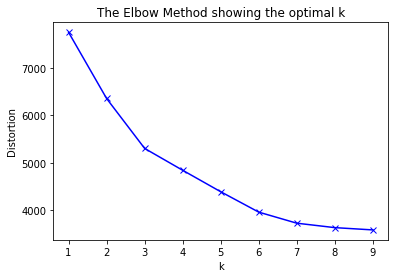

In [64]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


X = df
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    kmeanModel.fit(df)
    distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])


plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [3]:
df = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/4-3-clustering/data/college.csv')

In [ ]:
# Code taken from the lectures

For n_clusters = 2 The average silhouette_score is : 0.5599267973651544
For n_clusters = 3 The average silhouette_score is : 0.4759356971996221
For n_clusters = 4 The average silhouette_score is : 0.3820802411194842
For n_clusters = 5 The average silhouette_score is : 0.38740674110376444
For n_clusters = 6 The average silhouette_score is : 0.30817920333472854


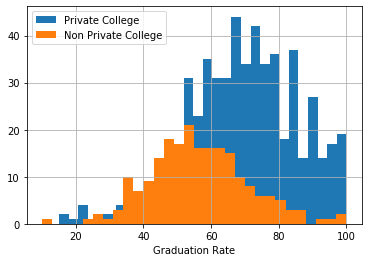

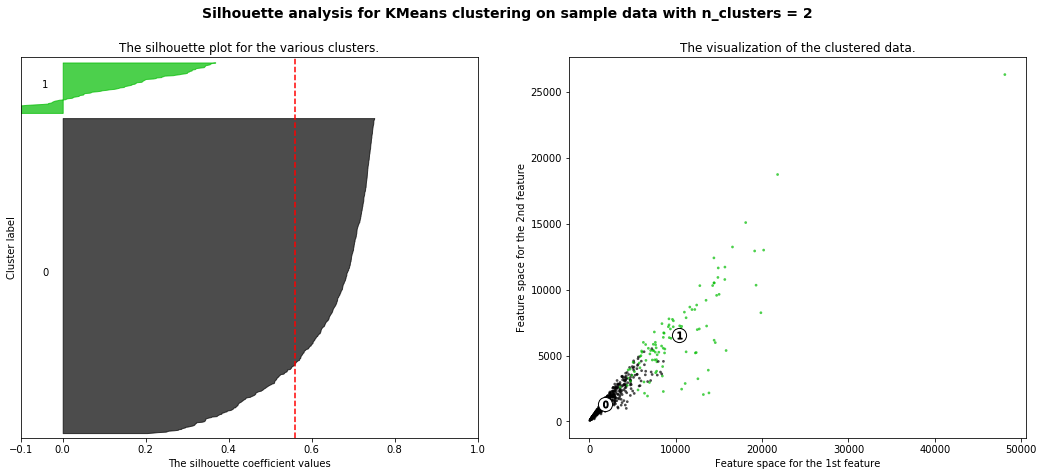

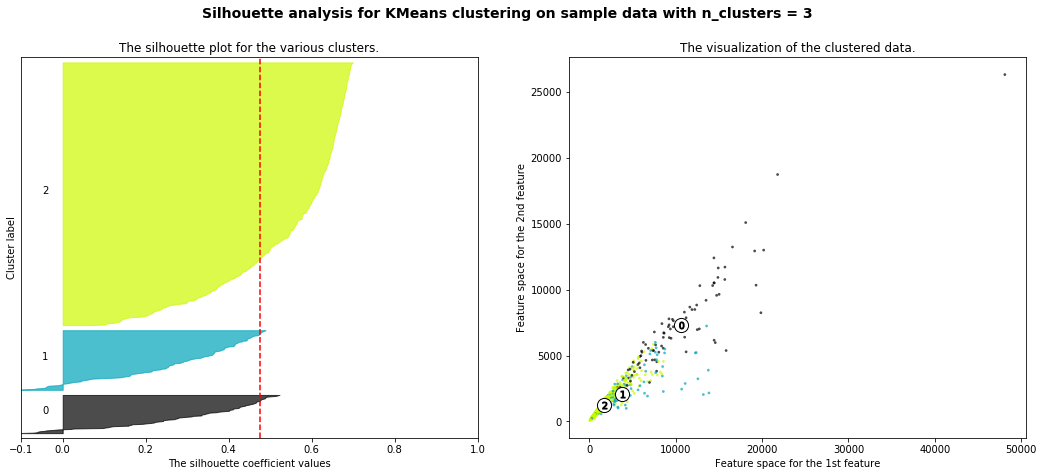

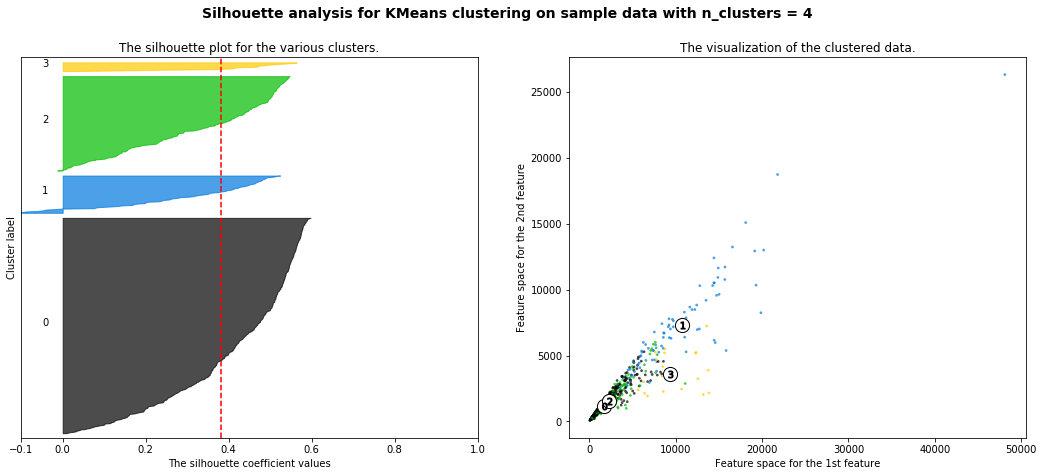

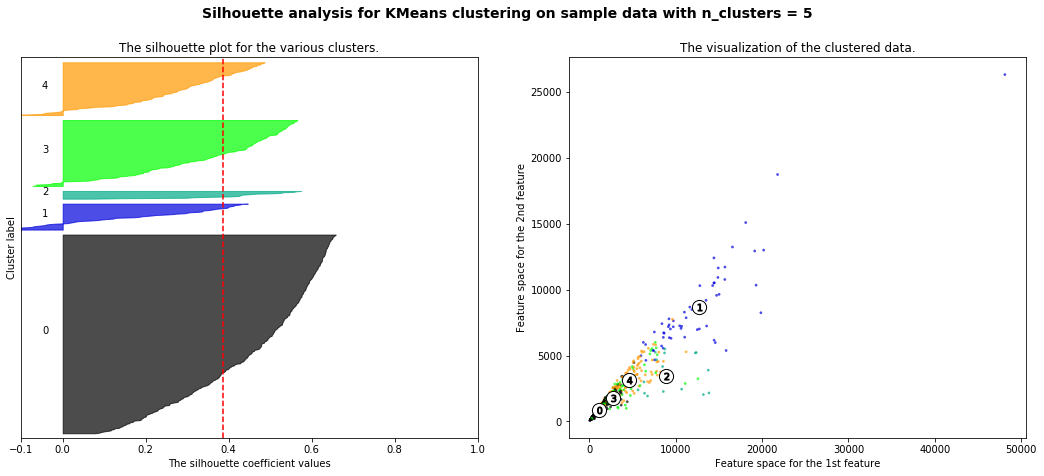

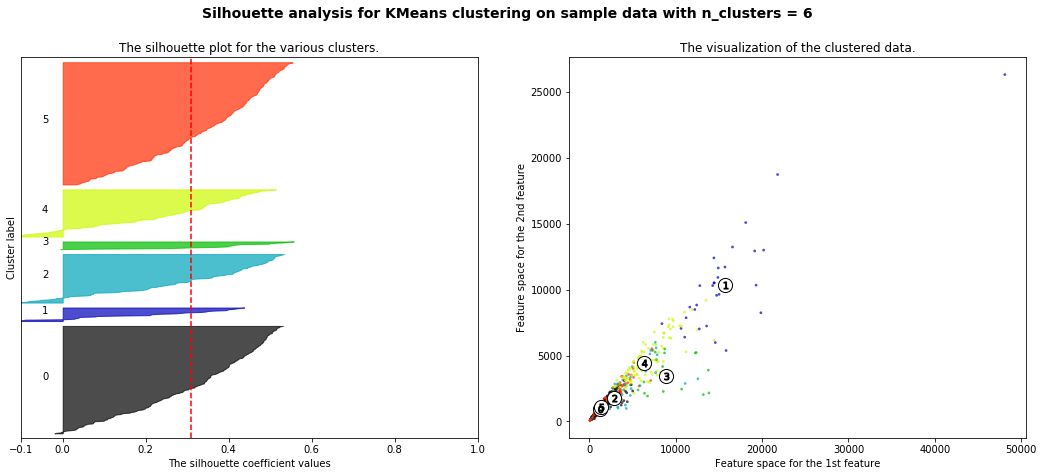

In [4]:
pd.set_option('display.float', '{:.2f}'.format) 
df.describe()

#grad_rate has a max of 118%, changing that to 100 to even out the data
df.loc[df['Grad.Rate'] > 100, 'Grad.Rate'] = 100

import matplotlib.pyplot as plt
df.loc[df.Private == 'Yes', 'Grad.Rate'].hist(label = "Private College", bins=30)
df.loc[df.Private == 'No', 'Grad.Rate'].hist(label = "Non Private College", bins=30)
plt.xlabel('Graduation Rate')
plt.legend() #Showing the grad rate based on private of public

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(df.drop(['Private', 'Unnamed: 0'],axis=1))
kmeans.cluster_centers_

kmeans.predict(df.drop(['Private', 'Unnamed: 0'],axis=1))

from scipy.stats import mode
import numpy as np
labels = np.zeros_like(df.Private)
mask = (df.Private == 'No')
labels[mask] = mode(df.Private[mask])[0]

mask = (df.Private == 'Yes')
labels[mask] = mode(df.Private[mask])[0]

df['prediction'] = labels

kmeans_list = []
for i in range(2, 10):
  k = i
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(df.drop(['Private', 'Unnamed: 0', 'prediction'],axis=1))
  kmeans.cluster_centers_
  kmeans_list.append(kmeans.inertia_)

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = df.drop(['Private', 'Unnamed: 0', 'prediction'],axis=1).to_numpy()
df[df['Private'] == 'Yes'] = 1
df[df['Private'] == 'No'] = 0
y = df.Private
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

In [ ]:
"""
Looking at the silhouettes scores it seems 2 clusters is best, as the others have below average scores.
also theres wide fluctuations in the silhouette graphs 4,6
2 and 5 have fairly better clustering.

Although I would have to chose 3 as the optimal number, as thats what my elbow method has shown.
"""